In [1]:
%matplotlib inline
import numpy as np
import gym
from tqdm import tqdm # progress bar
import matplotlib.pyplot as plt

# Intro
Describe what cartpole is here

Let's explore the model-based approach. Suppose *s*, *a*, and *s'* denote state, action and the next state respectively. We will learn the function that maps *(s, a) -> s'*. Then we will select actions using the dynamics model to evaluate future states.

a) In order to learn the dynamics model for the environment, you must first collect data *(s, a) -> s'*. Fill in the following function to gather a dataset. Starting with initial state, sample an action randomly, step the environment to get the next state. Repeat until the episode is over. Perfrom this procedure for num_rollouts episodes. 

In [2]:
env = gym.make('CartPole-v0')
max_rollout_length = 200

def gather_random_dataset(num_rollouts):
    states, actions, next_states = [], [], []
    for _ in tqdm(range(num_rollouts)):
            state = env.reset()
            done = False
            t = 0
            while not done:
                action = np.random.choice([0, 1]) # flip a coin to sample a random action. Valid action is either 0 or 1
                next_state, reward, done, _ = env.step(action)
                done = done or (t >= max_rollout_length)
                # save the data to corresponding arrays
                states.append(state)
                actions.append(action)
                next_states.append(next_state)
                state = next_state
                t += 1
    return np.array(states), np.array(actions)[:, None], np.array(next_states)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
states, actions, next_states = gather_random_dataset(100)
print(states.shape)
print(actions.shape)

100%|██████████| 100/100 [00:00<00:00, 1964.21it/s]

(2138, 4)
(2138, 1)


b) You will now model the environment with a polynomial dynamics function. First, augment the state with two additional features partiuclarly useful for this problem - cosine and sine of theta. Then concatenate augmented states and actions, and use those as input to make polynomial features. Fit the polynomial coefficients using OLS.

/Users/maksimivanov/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


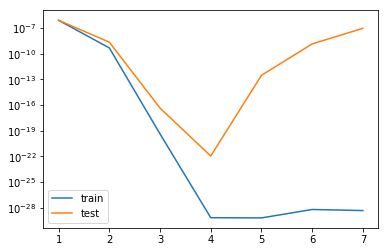

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


train_mses = []
test_mses = []

# augment observation cos(theta) and sin(theta)
states_aug = np.concatenate([states, np.cos(states[: , -2])[:, None], np.sin(states[: , -2])[:, None]],
                            axis = 1)
# concatenate state and action 
s_a = np.concatenate([states_aug, actions], axis = 1)
y = next_states
models = dict()

# make polynomial features from concatenated state-action
for deg in range(1, 8):
    polyFeatures = PolynomialFeatures(degree=deg)
    X = polyFeatures.fit_transform(s_a)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, shuffle=True)
    # our environment is noiseless so OLS will work
    w, _, _, _ = np.linalg.lstsq(X_train, y_train)
    models[deg] = (w, deg)
    y_pred = np.matmul(X_test,w)
    # compute error
    mse_test = mean_squared_error(y_test, y_pred)
    mse_train = mean_squared_error(y_train, np.matmul(X_train,w))
    train_mses.append(mse_train)
    test_mses.append(mse_test)

plt.figure()
xs = list(range(1,8))
plt.semilogy(xs, train_mses, label = 'train')
plt.semilogy(xs, test_mses, label = 'test')
plt.legend()


In [5]:
coeff, deg = models[4]
polyFeatures = PolynomialFeatures(degree=deg)
theta_threshold_radians = 12 * 4 * np.pi / 360
x_threshold = 10

def predict_next_states(states, actions):
    states_aug = np.concatenate([states, np.cos(states[: , 2])[:, None], np.sin(states[: , 2])[:, None]], axis = 1)
    s_a = np.concatenate([states_aug, actions[:, None]], axis = 1)
    X = polyFeatures.fit_transform(s_a)
    pred = np.matmul(X, coeff)
    pred = np.clip(pred, -10, 10)
    return pred

def compute_rewards(states):
    x = states[:, 0]
    theta = states[:, 2]
    failed_x =  np.logical_or(x < -x_threshold, x > x_threshold)
    failed_theta = np.logical_or(theta < -theta_threshold_radians, theta > theta_threshold_radians)
    return np.logical_not(np.logical_or(failed_x, failed_theta)).astype(np.int32)

def reward_fn(states):
    x = states[:, 0]
    theta = states[:, 2]
    x_reward = np.min((x_threshold + x, x_threshold - x), axis = 0)
    theta_reward = np.min(((theta_threshold_radians + theta, theta_threshold_radians - theta)), axis= 0)
    return x_reward + theta_reward
    
# def plan_random(state, horizon=30):
#     total_rewards = np.zeros(2)
#     prev_states = np.vstack([state, state])
#     for i in range(horizon):
#         actions = np.random.choice([0, 1], size=2)
#         next_states = predict_next_states(prev_states, actions)
#         rewards = cost_fn(next_states)
#         total_rewards += rewards
#         prev_states = next_states
#     return np.argmax(total_rewards)

def unroll(state, horizon):
    # print('horizon', horizon)
    cur_state_cost = reward_fn(state[None, :])
    if horizon == 0 or cur_state_cost <= 0:
        return cur_state_cost
    prev_states = np.vstack([state, state])
    actions = np.array([0, 1])
    next_states = predict_next_states(prev_states, actions)
    rewards = [unroll(next_states[0, :], horizon - 1), unroll(next_states[1, :], horizon - 1)]
    return reward_fn(state[None, :]) + np.max(rewards)

def plan(state, horizon=5):
    prev_states = np.vstack([state, state])
    actions = np.array([0, 1])
    next_states = predict_next_states(prev_states, actions)
    rewards = [unroll(next_states[0, :], horizon - 1), unroll(next_states[1, :], horizon - 1)]
    return np.argmax(rewards)
        

                

In [ ]:
def gather_rollouts(num_rollouts, horizon=3):
    states, actions, next_states = [], [], []
    for e in range(num_rollouts):
            state = env.reset()
            done = False
            t = 0
            r  = 0
            while not done:
                action = plan(state, horizon) # flip a coin to sample a random action. Valid action is either 0 or 1
                next_state, reward, done, _ = env.step(action)
                done = done or (t >= max_rollout_length)
                # save the data to corresponding arrays
                if not done:
                    states.append(state)
                    actions.append(action)
                    next_states.append(next_state)
                    state = next_state
                r += reward
                t += 1
            print('Episode:', e)
            print('Return:', r)
    #return np.array(states), np.array(actions)[:, None], np.array(next_states)

gather_rollouts(100, 3)

Episode: 0
Return: 200.0
Episode: 1
Return: 200.0
Episode: 2
Return: 200.0
